# 🎯 Detección de Objetos con YOLO

Este notebook implementa un sistema de detección de objetos usando YOLO (You Only Look Once) que puede identificar al menos 2 clases diferentes de objetos en una imagen.

## 📋 Características:
- Detección de múltiples clases de objetos
- Función `detectar_objetos_yolo(imagen)` personalizada
- Visualización de resultados con cajas delimitadoras
- Soporte para imágenes locales y desde URL

## 🚀 **COMPATIBLE CON GOOGLE COLAB**

### ⚡ **Optimizaciones para Colab:**
- ✅ Instalación automática de dependencias
- ✅ Descarga automática de modelos pre-entrenados  
- ✅ Compatible con GPU gratuita de Colab
- ✅ Gestión automática de memoria
- ✅ URLs de ejemplo funcionan sin configuración adicional

### 💾 **Guardado de resultados:**
- Los archivos CSV se guardan en `/content/` de Colab
- Las imágenes se muestran directamente en el notebook
- Puedes descargar resultados desde el panel de archivos

---

## 1️⃣ Importar Librerías Necesarias

Primero importamos todas las librerías requeridas para la detección de objetos con YOLO.

In [ ]:
# ================================
# INSTALACIÓN DE DEPENDENCIAS (COMPATIBLE CON COLAB)
# ================================

print("📦 Instalando dependencias...")

# Instalación básica
!pip install -q ultralytics opencv-python matplotlib pillow requests numpy pandas

# PyTorch y dependencias de deep learning
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Segment Anything Model (SAM)
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

# MiDaS dependencies
!pip install -q timm transformers

# Verificar instalaciones principales
try:
    import ultralytics
    print("✅ Ultralytics (YOLO) instalado")
except ImportError:
    print("❌ Error con Ultralytics")

try:
    import segment_anything
    print("✅ Segment Anything instalado")
except ImportError:
    print("❌ Error con Segment Anything")

try:
    import transformers
    print("✅ Transformers (MiDaS) instalado")
except ImportError:
    print("❌ Error con Transformers")

print("🎉 Instalación de dependencias completada")

# Importar librerías básicas
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import os
import pandas as pd

# Importar YOLO
from ultralytics import YOLO

# Importar SAM
try:
    from segment_anything import SamPredictor, sam_model_registry
    print("✅ SAM importado correctamente")
except ImportError:
    print("⚠️ SAM no disponible. Instalando...")
    !pip install git+https://github.com/facebookresearch/segment-anything.git
    from segment_anything import SamPredictor, sam_model_registry

# Importar MiDaS
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose

try:
    import timm
    from transformers import DPTImageProcessor, DPTForDepthEstimation
    print("✅ MiDaS dependencies importadas correctamente")
except ImportError:
    print("⚠️ Instalando dependencias de MiDaS...")
    !pip install timm transformers

print("✅ Todas las librerías importadas correctamente")
print("📦 Versiones:")
print(f"   - OpenCV: {cv2.__version__}")
print(f"   - NumPy: {np.__version__}")
print(f"   - PIL: {Image.__version__}")
print(f"   - PyTorch: {torch.__version__}")
print(f"   - Matplotlib: {plt.matplotlib.__version__}")

In [ ]:
# ================================
# CONFIGURACIÓN ESPECÍFICA PARA GOOGLE COLAB
# ================================

# Verificar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🔵 Ejecutando en Google Colab")

    # Configurar para usar GPU si está disponible
    import torch
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"🚀 GPU detectada: {torch.cuda.get_device_name(0)}")
        print(f"💾 Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    else:
        device = torch.device('cpu')
        print("⚠️ GPU no disponible, usando CPU")

    # Configurar directorio de trabajo en Colab
    import os
    os.chdir('/content')
    print(f"📁 Directorio de trabajo: {os.getcwd()}")

    # Mostrar información del sistema
    print("🖥️ Información del sistema Colab:")
    !nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader,nounits

except ImportError:
    IN_COLAB = False
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("🟡 Ejecutando en entorno local")
    print(f"💻 Dispositivo: {device}")

print(f"✅ Configuración completada - Dispositivo: {device}")

## 2️⃣ Cargar Modelo YOLO

Cargamos el modelo YOLO preentrenado. Usaremos YOLOv8 que puede detectar 80 clases diferentes de objetos.

In [ ]:
# ================================
# CARGA DE MODELOS (OPTIMIZADO PARA COLAB)
# ================================

# Cargar modelo SAM
print("🔄 Cargando modelo SAM...")
try:
    # Descargar modelo SAM si no existe (versión más ligera para Colab)
    sam_checkpoint = "sam_vit_b_01ec64.pth"  # Modelo base más ligero
    if not os.path.exists(sam_checkpoint):
        print("📥 Descargando modelo SAM (ViT-B)...")
        !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

    sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
    if IN_COLAB and torch.cuda.is_available():
        sam = sam.to(device)
        print(f"🚀 SAM cargado en GPU: {device}")
    sam_predictor = SamPredictor(sam)
    print("✅ Modelo SAM cargado correctamente")
except Exception as e:
    print(f"⚠️ Error cargando SAM: {e}")
    print("Continuando sin SAM...")
    sam_predictor = None

# Cargar modelo MiDaS para estimación de profundidad
print("🔄 Cargando modelo MiDaS...")
try:
    # Usar modelo más ligero para Colab si hay limitaciones de memoria
    if IN_COLAB:
        # Modelo más eficiente para Colab
        midas_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
        midas_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas")
        print("✅ Modelo MiDaS (DPT-Hybrid) cargado para Colab")
    else:
        # Modelo de alta calidad para entorno local
        midas_processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
        midas_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")
        print("✅ Modelo MiDaS (DPT-Large) cargado para entorno local")

    # Mover a GPU si está disponible
    if torch.cuda.is_available():
        midas_model = midas_model.to(device)
        print(f"🚀 MiDaS movido a GPU: {device}")

except Exception as e:
    print(f"⚠️ Error cargando MiDaS: {e}")
    midas_processor = None
    midas_model = None

In [ ]:
# Cargar el modelo YOLO preentrenado
print("🔄 Cargando modelo YOLO...")
model = YOLO('yolov8n.pt')  # Modelo nano (más rápido)
# model = YOLO('yolov8s.pt')  # Modelo small (más preciso)
# model = YOLO('yolov8m.pt')  # Modelo medium (balance)

print("✅ Modelo YOLO cargado correctamente")

# Mostrar las clases que puede detectar el modelo
class_names = model.names
print(f"📊 Total de clases detectables: {len(class_names)}")
print("🏷️ Algunas clases incluidas:")
for i, class_name in enumerate(list(class_names.values())[:20]):
    print(f"   {i}: {class_name}")
print("   ...")

## 3️⃣ Cargar Imagen de Prueba

Cargamos una imagen para realizar la detección. Puedes usar una imagen local o una URL.

In [ ]:
def cargar_imagen(fuente):
    """
    Carga una imagen desde una ruta local o URL

    Args:
        fuente (str): Ruta local o URL de la imagen

    Returns:
        numpy.ndarray: Imagen en formato OpenCV (BGR)
    """
    try:
        if fuente.startswith(('http://', 'https://')):
            # Cargar desde URL
            response = requests.get(fuente)
            imagen_pil = Image.open(BytesIO(response.content))
            imagen_rgb = np.array(imagen_pil)
            imagen_bgr = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2BGR)
            return imagen_bgr
        else:
            # Cargar desde archivo local
            return cv2.imread(fuente)
    except Exception as e:
        print(f"❌ Error al cargar la imagen: {e}")
        return None

# Ejemplo de imagen desde URL (contiene múltiples objetos)
url_imagen = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSOjY5HT3KkIkmjSZV1wpRwEhBpfVsPCtSzCg&s"

# Puedes cambiar esta línea para usar una imagen local
# imagen = cargar_imagen("ruta/a/tu/imagen.jpg")
imagen = cargar_imagen(url_imagen)

if imagen is not None:
    print("✅ Imagen cargada correctamente")
    print(f"📏 Dimensiones: {imagen.shape}")

    # Mostrar la imagen original
    plt.figure(figsize=(10, 8))
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    plt.imshow(imagen_rgb)
    plt.title("🖼️ Imagen Original")
    plt.axis('off')
    plt.show()
else:
    print("❌ No se pudo cargar la imagen")

## 4️⃣ Definir la Función `detectar_objetos_yolo`

Esta es la función principal que implementa la detección de objetos usando YOLO.

In [ ]:
def detectar_objetos_yolo(imagen, confianza_min=0.5, iou_threshold=0.45):
    """
    Detecta objetos en una imagen usando YOLO

    Args:
        imagen (numpy.ndarray): Imagen en formato OpenCV (BGR)
        confianza_min (float): Umbral mínimo de confianza (0-1)
        iou_threshold (float): Umbral de IoU para supresión no máxima

    Returns:
        dict: Diccionario con los resultados de la detección
            - 'imagen_con_detecciones': Imagen con cajas dibujadas
            - 'detecciones': Lista de objetos detectados
            - 'clases_detectadas': Set de clases únicas detectadas
            - 'total_objetos': Número total de objetos detectados
    """

    # Realizar la detección
    resultados = model(imagen, conf=confianza_min, iou=iou_threshold)

    # Crear una copia de la imagen para dibujar
    imagen_resultado = imagen.copy()

    # Listas para almacenar información de detecciones
    detecciones = []
    clases_detectadas = set()

    # Procesar cada detección
    for resultado in resultados:
        cajas = resultado.boxes.xyxy.cpu().numpy()  # Coordenadas de las cajas
        confianzas = resultado.boxes.conf.cpu().numpy()  # Confianzas
        clases = resultado.boxes.cls.cpu().numpy()  # Clases

        for i, (caja, confianza, clase) in enumerate(zip(cajas, confianzas, clases)):
            # Extraer coordenadas
            x1, y1, x2, y2 = map(int, caja)

            # Obtener nombre de la clase
            nombre_clase = model.names[int(clase)]
            clases_detectadas.add(nombre_clase)

            # Guardar información de la detección
            deteccion = {
                'clase': nombre_clase,
                'confianza': float(confianza),
                'caja': [x1, y1, x2, y2],
                'centro': [(x1 + x2) // 2, (y1 + y2) // 2],
                'area': (x2 - x1) * (y2 - y1)
            }
            detecciones.append(deteccion)

            # Dibujar caja delimitadora
            color = (0, 255, 0)  # Verde
            cv2.rectangle(imagen_resultado, (x1, y1), (x2, y2), color, 2)

            # Dibujar etiqueta con clase y confianza
            etiqueta = f"{nombre_clase}: {confianza:.2f}"
            tamano_texto = cv2.getTextSize(etiqueta, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

            # Fondo para el texto
            cv2.rectangle(imagen_resultado,
                         (x1, y1 - tamano_texto[1] - 10),
                         (x1 + tamano_texto[0], y1),
                         color, -1)

            # Texto
            cv2.putText(imagen_resultado, etiqueta,
                       (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                       (255, 255, 255), 2)

    # Crear diccionario de resultados
    resultados_deteccion = {
        'imagen_con_detecciones': imagen_resultado,
        'detecciones': detecciones,
        'clases_detectadas': clases_detectadas,
        'total_objetos': len(detecciones)
    }

    return resultados_deteccion

print("✅ Función detectar_objetos_yolo definida correctamente")

## 5️⃣ Realizar Detección de Objetos en la Imagen

Aplicamos la función `detectar_objetos_yolo` a la imagen cargada.

In [37]:
# Verificar que tenemos una imagen cargada
if imagen is not None:
    print("🔍 Iniciando detección de objetos...")

    # Ejecutar la detección
    resultados = detectar_objetos_yolo(imagen, confianza_min=0.5)

    # Mostrar estadísticas de la detección
    print(f"✅ Detección completada!")
    print(f"📊 Total de objetos detectados: {resultados['total_objetos']}")
    print(f"🏷️ Clases detectadas ({len(resultados['clases_detectadas'])}): {', '.join(sorted(resultados['clases_detectadas']))}")

    # Mostrar detalles de cada detección
    print("\n📋 Detalles de las detecciones:")
    for i, deteccion in enumerate(resultados['detecciones'], 1):
        print(f"   {i}. {deteccion['clase']} (confianza: {deteccion['confianza']:.2f})")
        print(f"      📍 Posición: {deteccion['caja']}")
        print(f"      📐 Área: {deteccion['area']} píxeles")

    # Verificar que se detectaron al menos 2 clases diferentes
    if len(resultados['clases_detectadas']) >= 2:
        print(f"\n🎯 ¡Éxito! Se detectaron {len(resultados['clases_detectadas'])} clases diferentes.")
    else:
        print(f"\n⚠️ Solo se detectó {len(resultados['clases_detectadas'])} clase. Prueba con otra imagen o ajusta el umbral de confianza.")

else:
    print("❌ No hay imagen cargada para procesar")

🔍 Iniciando detección de objetos...

0: 448x640 5 persons, 1 bicycle, 2 cars, 321.0ms
Speed: 5.8ms preprocess, 321.0ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)
✅ Detección completada!
📊 Total de objetos detectados: 8
🏷️ Clases detectadas (3): bicycle, car, person

📋 Detalles de las detecciones:
   1. person (confianza: 0.84)
      📍 Posición: [41, 34, 86, 147]
      📐 Área: 5085 píxeles
   2. person (confianza: 0.83)
      📍 Posición: [124, 74, 157, 145]
      📐 Área: 2343 píxeles
   3. car (confianza: 0.70)
      📍 Posición: [209, 55, 277, 145]
      📐 Área: 6120 píxeles
   4. person (confianza: 0.61)
      📍 Posición: [0, 48, 11, 94]
      📐 Área: 506 píxeles
   5. person (confianza: 0.58)
      📍 Posición: [10, 51, 22, 83]
      📐 Área: 384 píxeles
   6. car (confianza: 0.55)
      📍 Posición: [154, 74, 172, 91]
      📐 Área: 306 píxeles
   7. bicycle (confianza: 0.55)
      📍 Posición: [43, 89, 81, 169]
      📐 Área: 3040 píxeles
   8. person (confianza: 0.5

## 6️⃣ Visualizar Resultados de la Detección

Mostramos la imagen original junto con los resultados de la detección.

In [ ]:
# Mostrar comparación lado a lado
if imagen is not None and 'resultados' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Imagen original
    imagen_rgb_original = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    axes[0].imshow(imagen_rgb_original)
    axes[0].set_title("🖼️ Imagen Original", fontsize=16)
    axes[0].axis('off')

    # Imagen con detecciones
    imagen_rgb_detecciones = cv2.cvtColor(resultados['imagen_con_detecciones'], cv2.COLOR_BGR2RGB)
    axes[1].imshow(imagen_rgb_detecciones)
    axes[1].set_title(f"🎯 Detecciones YOLO ({resultados['total_objetos']} objetos)", fontsize=16)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Mostrar solo la imagen con detecciones en tamaño grande
    plt.figure(figsize=(15, 12))
    plt.imshow(imagen_rgb_detecciones)
    plt.title(f"🎯 Resultado Final - {resultados['total_objetos']} objetos detectados en {len(resultados['clases_detectadas'])} clases",
              fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Crear gráfico de barras con las clases detectadas
    if resultados['clases_detectadas']:
        clases_conteo = {}
        for deteccion in resultados['detecciones']:
            clase = deteccion['clase']
            clases_conteo[clase] = clases_conteo.get(clase, 0) + 1

        plt.figure(figsize=(12, 6))
        clases = list(clases_conteo.keys())
        conteos = list(clases_conteo.values())

        bars = plt.bar(clases, conteos, color='skyblue', edgecolor='navy')
        plt.title('📊 Distribución de Objetos Detectados', fontsize=16, fontweight='bold')
        plt.xlabel('Clases de Objetos', fontsize=12)
        plt.ylabel('Cantidad Detectada', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Agregar valores en las barras
        for bar, count in zip(bars, conteos):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    str(count), ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.grid(axis='y', alpha=0.3)
        plt.show()

else:
    print("❌ No hay resultados para mostrar. Asegúrate de ejecutar primero la detección.")

## 7️⃣ Ejemplos Adicionales y Personalización

Aquí puedes probar con diferentes imágenes y ajustar parámetros.

In [ ]:
# Función para probar diferentes umbrales de confianza
def comparar_umbrales_confianza(imagen, umbrales=[0.3, 0.5, 0.7]):
    """
    Compara los resultados de detección con diferentes umbrales de confianza
    """
    if imagen is None:
        print("❌ No hay imagen cargada")
        return

    fig, axes = plt.subplots(1, len(umbrales), figsize=(20, 6))
    if len(umbrales) == 1:
        axes = [axes]

    for i, umbral in enumerate(umbrales):
        resultado = detectar_objetos_yolo(imagen, confianza_min=umbral)
        imagen_rgb = cv2.cvtColor(resultado['imagen_con_detecciones'], cv2.COLOR_BGR2RGB)

        axes[i].imshow(imagen_rgb)
        axes[i].set_title(f"Confianza ≥ {umbral}\n{resultado['total_objetos']} objetos", fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# URLs de ejemplo con diferentes tipos de objetos
ejemplos_imagenes = {
    "Calle con vehículos": "https://images.unsplash.com/photo-1449824913935-59a10b8d2000?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2070&q=80",
    "Animales": "https://images.unsplash.com/photo-1564349683136-77e08dba1ef7?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2112&q=80",
    "Cocina": "https://images.unsplash.com/photo-1556909114-f6e7ad7d3136?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2070&q=80"
}

print("🔧 Funciones de personalización cargadas")
print("📝 Puedes usar las siguientes funciones:")
print("   - comparar_umbrales_confianza(imagen, [0.3, 0.5, 0.7])")
print("   - detectar_objetos_yolo(imagen, confianza_min=0.5)")
print("\n🖼️ URLs de ejemplo disponibles:")
for nombre, url in ejemplos_imagenes.items():
    print(f"   - {nombre}: {url[:50]}...")

In [ ]:
# Ejemplo: Probar con una imagen de cocina
print("🍳 Probando con imagen de cocina...")
imagen_cocina = cargar_imagen(ejemplos_imagenes["Cocina"])

if imagen_cocina is not None:
    # Detectar objetos
    resultado_cocina = detectar_objetos_yolo(imagen_cocina, confianza_min=0.4)

    print(f"✅ Detectados {resultado_cocina['total_objetos']} objetos")
    print(f"🏷️ Clases: {', '.join(sorted(resultado_cocina['clases_detectadas']))}")

    # Mostrar resultado
    plt.figure(figsize=(12, 8))
    imagen_rgb = cv2.cvtColor(resultado_cocina['imagen_con_detecciones'], cv2.COLOR_BGR2RGB)
    plt.imshow(imagen_rgb)
    plt.title(f"🍳 Detección en Cocina - {resultado_cocina['total_objetos']} objetos", fontsize=16)
    plt.axis('off')
    plt.show()

    # Comparar diferentes umbrales
    print("\n🔍 Comparando diferentes umbrales de confianza:")
    comparar_umbrales_confianza(imagen_cocina, [0.3, 0.5, 0.7])
else:
    print("❌ No se pudo cargar la imagen de cocina")

## 🎯 Conclusión

¡Felicidades! Has implementado exitosamente un sistema de detección de objetos usando YOLO que cumple con los siguientes requisitos:

### ✅ Requisitos Cumplidos:
- **Detección de al menos 2 clases diferentes**: ✓ El modelo YOLO puede detectar 80 clases diferentes
- **Función `detectar_objetos_yolo(imagen)`**: ✓ Implementada con parámetros configurables
- **Visualización de resultados**: ✓ Con cajas delimitadoras y etiquetas
- **Archivo .ipynb**: ✓ Implementado en Jupyter Notebook

### 🚀 Características Adicionales:
- Carga de imágenes desde URL o archivos locales
- Parámetros ajustables (confianza, IoU threshold)
- Estadísticas detalladas de detección
- Comparación visual de resultados
- Gráficos de distribución de clases

### 💡 Cómo usar:
```python
# Cargar imagen
imagen = cargar_imagen("ruta/imagen.jpg")

# Detectar objetos
resultados = detectar_objetos_yolo(imagen, confianza_min=0.5)

# Ver resultados
print(f"Clases detectadas: {resultados['clases_detectadas']}")
```

### 🔧 Próximos pasos:
- Probar con tus propias imágenes
- Experimentar con diferentes umbrales
- Usar modelos YOLO más grandes para mayor precisión
- Implementar detección en video en tiempo real

## 8️⃣ Segmentación con SAM

Implementamos la segmentación precisa usando las bounding boxes de YOLO como prompts para SAM (Segment Anything Model).

In [ ]:
def segmentar_con_sam(imagen, boxes):
    """
    Segmenta objetos usando SAM con bounding boxes como prompts

    Args:
        imagen (numpy.ndarray): Imagen en formato OpenCV (BGR)
        boxes (list): Lista de bounding boxes [x1, y1, x2, y2]

    Returns:
        list: Lista de máscaras de segmentación (numpy arrays booleanos)
    """
    if sam_predictor is None:
        print("❌ SAM no está disponible")
        # Retornar máscaras vacías como fallback
        h, w = imagen.shape[:2]
        return [np.zeros((h, w), dtype=bool) for _ in boxes]

    # Configurar la imagen en SAM
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    sam_predictor.set_image(imagen_rgb)

    masks = []

    print(f"🔍 Segmentando {len(boxes)} objetos con SAM...")

    for i, box in enumerate(boxes):
        try:
            # Convertir box a formato SAM [x1, y1, x2, y2]
            input_box = np.array(box, dtype=np.float32)

            # Generar máscara usando la bounding box como prompt
            mask, score, logits = sam_predictor.predict(
                box=input_box,
                multimask_output=False
            )

            # Tomar la primera máscara y asegurar formato booleano
            mask_resultado = mask[0].astype(bool)
            masks.append(mask_resultado)

        except Exception as e:
            print(f"⚠️ Error segmentando objeto {i}: {e}")
            # Crear máscara vacía como fallback
            h, w = imagen.shape[:2]
            masks.append(np.zeros((h, w), dtype=bool))

    print(f"✅ Segmentación completada: {len(masks)} máscaras generadas")

    return masks

def superponer_mascaras(imagen_rgb, masks, alpha=0.6):
    """
    Superpone las máscaras sobre la imagen RGB

    Args:
        imagen_rgb (numpy.ndarray): Imagen en formato RGB
        masks (list): Lista de máscaras booleanas
        alpha (float): Transparencia de las máscaras

    Returns:
        numpy.ndarray: Imagen con máscaras superpuestas
    """
    if not masks or len(masks) == 0:
        return imagen_rgb.copy()

    imagen_resultado = imagen_rgb.copy()

    # Colores para las máscaras
    colores = [
        [255, 0, 0],    # Rojo
        [0, 255, 0],    # Verde
        [0, 0, 255],    # Azul
        [255, 255, 0],  # Amarillo
        [255, 0, 255],  # Magenta
        [0, 255, 255],  # Cian
        [255, 128, 0],  # Naranja
        [128, 0, 255],  # Violeta
    ]

    for i, mask in enumerate(masks):
        if mask is not None and np.any(mask):
            color = colores[i % len(colores)]

            # Aplicar máscara con transparencia
            for c in range(3):
                imagen_resultado[:, :, c] = np.where(
                    mask,
                    imagen_resultado[:, :, c] * (1 - alpha) + color[c] * alpha,
                    imagen_resultado[:, :, c]
                )

            # Dibujar contorno de la máscara
            try:
                contornos, _ = cv2.findContours(
                    mask.astype(np.uint8),
                    cv2.RETR_EXTERNAL,
                    cv2.CHAIN_APPROX_SIMPLE
                )
                cv2.drawContours(imagen_resultado, contornos, -1, color, 2)
            except Exception as e:
                print(f"⚠️ Error dibujando contorno {i}: {e}")

    return imagen_resultado

print("✅ Funciones de segmentación con SAM definidas")

## 9️⃣ Estimación de Profundidad con MiDaS

Generamos un mapa de profundidad usando el modelo MiDaS v3 (DPT-Large) para estimar la profundidad relativa de cada píxel.

In [ ]:
def estimar_profundidad_midas(imagen):
    """
    Estima la profundidad de una imagen usando MiDaS (DPT-Large)

    Args:
        imagen (numpy.ndarray): Imagen en formato OpenCV (BGR)

    Returns:
        dict: Diccionario con mapa de profundidad y estadísticas
    """
    if midas_processor is None or midas_model is None:
        print("❌ MiDaS no está disponible")
        return None

    print("🔍 Estimando profundidad con MiDaS...")

    # Convertir a RGB y preparar para MiDaS
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    imagen_pil = Image.fromarray(imagen_rgb)

    # Procesar imagen con MiDaS
    inputs = midas_processor(images=imagen_pil, return_tensors="pt")

    # Generar mapa de profundidad
    with torch.no_grad():
        outputs = midas_model(**inputs)
        predicted_depth = outputs.predicted_depth

    # Postprocesar el mapa de profundidad
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=imagen_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    )

    # Convertir a numpy y normalizar
    depth_map = prediction.squeeze().cpu().numpy()

    # Normalizar a rango 0-1 (valores más altos = más cerca)
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    depth_normalized = (depth_map - depth_min) / (depth_max - depth_min)

    # Invertir para que 0=lejos, 1=cerca (más intuitivo)
    depth_normalized = 1.0 - depth_normalized

    resultado = {
        'depth_map': depth_normalized,
        'depth_raw': depth_map,
        'depth_min': float(depth_min),
        'depth_max': float(depth_max),
        'shape': depth_map.shape
    }

    print(f"✅ Mapa de profundidad generado: {depth_map.shape}")
    print(f"📊 Rango de profundidad: {depth_min:.3f} - {depth_max:.3f}")

    return resultado

def visualizar_mapa_profundidad(depth_map, titulo="Mapa de Profundidad"):
    """
    Visualiza el mapa de profundidad con diferentes representaciones
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Mapa en escala de grises
    axes[0].imshow(depth_map, cmap='gray')
    axes[0].set_title(f"{titulo} - Escala de Grises")
    axes[0].axis('off')

    # Mapa con heatmap
    im1 = axes[1].imshow(depth_map, cmap='plasma')
    axes[1].set_title(f"{titulo} - Heatmap (Plasma)")
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Mapa con colores de profundidad
    im2 = axes[2].imshow(depth_map, cmap='viridis')
    axes[2].set_title(f"{titulo} - Viridis")
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

print("✅ Funciones de estimación de profundidad con MiDaS definidas")

## 🔟 Visualización Combinada

Combinamos todos los resultados: detección YOLO, segmentación SAM y mapas de profundidad MiDaS en una visualización completa.

In [ ]:
def visualizar_resultados(imagen, boxes, masks, depth_map, clases=None, confianzas=None):
    """
    Visualización combinada de detección YOLO, segmentación SAM y profundidad MiDaS

    Args:
        imagen (numpy.ndarray): Imagen original
        boxes (list): Lista de bounding boxes de YOLO
        masks (list): Lista de máscaras de SAM
        depth_map (numpy.ndarray): Mapa de profundidad de MiDaS
        clases (list): Lista de nombres de clases detectadas
        confianzas (list): Lista de confianzas de detección
    """

    # Configurar la figura con subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Imagen original con cajas YOLO
    plt.subplot(2, 3, 1)
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    imagen_con_cajas = imagen_rgb.copy()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(imagen_con_cajas, (x1, y1), (x2, y2), (0, 255, 0), 3)

        if clases and i < len(clases):
            label = f"{clases[i]}"
            if confianzas and i < len(confianzas):
                label += f": {confianzas[i]:.2f}"
            cv2.putText(imagen_con_cajas, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    plt.imshow(imagen_con_cajas)
    plt.title("🎯 Detección YOLO", fontsize=14, fontweight='bold')
    plt.axis('off')

    # 2. Imagen con máscaras SAM superpuestas
    plt.subplot(2, 3, 2)
    imagen_con_mascaras = superponer_mascaras(imagen_rgb, masks)
    plt.imshow(imagen_con_mascaras)
    plt.title("🎭 Segmentación SAM", fontsize=14, fontweight='bold')
    plt.axis('off')

    # 3. Mapa de profundidad
    plt.subplot(2, 3, 3)
    im_depth = plt.imshow(depth_map, cmap='plasma')
    plt.title("🌊 Profundidad MiDaS", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.colorbar(im_depth, fraction=0.046, pad=0.04)

    # 4. Combinación: cajas + máscaras + profundidad
    plt.subplot(2, 3, 4)
    imagen_combinada = imagen_con_mascaras.copy()

    # Superponer cajas sobre las máscaras
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(imagen_combinada, (x1, y1), (x2, y2), (255, 255, 0), 2)

        if clases and i < len(clases):
            label = clases[i]
            cv2.putText(imagen_combinada, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    plt.imshow(imagen_combinada)
    plt.title("🔄 YOLO + SAM", fontsize=14, fontweight='bold')
    plt.axis('off')

    # 5. Recortes individuales con fondo blanco
    plt.subplot(2, 3, 5)
    recortes = extraer_recortes_con_fondo_blanco(imagen_rgb, masks, boxes)
    if recortes:
        # Mostrar el primer recorte como ejemplo
        plt.imshow(recortes[0])
        plt.title(f"✂️ Recorte 1/{len(recortes)}", fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, "Sin recortes", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title("✂️ Recortes de Objetos", fontsize=14, fontweight='bold')
    plt.axis('off')

    # 6. Estadísticas de profundidad
    plt.subplot(2, 3, 6)
    if boxes and len(boxes) > 0:
        profundidades_promedio = calcular_profundidad_objetos(depth_map, boxes)
        if clases:
            labels = [f"{clase}\n({prof:.3f})" for clase, prof in zip(clases, profundidades_promedio)]
        else:
            labels = [f"Obj {i+1}\n({prof:.3f})" for i, prof in enumerate(profundidades_promedio)]

        colors = plt.cm.viridis(np.linspace(0, 1, len(profundidades_promedio)))
        bars = plt.bar(range(len(profundidades_promedio)), profundidades_promedio, color=colors)
        plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
        plt.ylabel('Profundidad Promedio')
        plt.title("📊 Profundidad por Objeto", fontsize=14, fontweight='bold')

        # Agregar valores en las barras
        for bar, prof in zip(bars, profundidades_promedio):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{prof:.3f}', ha='center', va='bottom', fontsize=10)
    else:
        plt.text(0.5, 0.5, "Sin objetos detectados", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title("📊 Profundidad por Objeto", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return recortes

def extraer_recortes_con_fondo_blanco(imagen_rgb, masks, boxes):
    """
    Extrae recortes de objetos con fondo blanco usando las máscaras
    """
    recortes = []

    for i, (mask, box) in enumerate(zip(masks, boxes)):
        if mask is not None:
            x1, y1, x2, y2 = map(int, box)

            # Crear recorte de la región
            recorte = imagen_rgb[y1:y2, x1:x2].copy()
            mask_recorte = mask[y1:y2, x1:x2]

            # Aplicar máscara: fondo blanco, objeto original
            recorte_con_fondo_blanco = np.ones_like(recorte) * 255
            for c in range(3):
                recorte_con_fondo_blanco[:, :, c] = np.where(
                    mask_recorte,
                    recorte[:, :, c],
                    255
                )

            recortes.append(recorte_con_fondo_blanco)

    return recortes

def calcular_profundidad_objetos(depth_map, boxes):
    """
    Calcula la profundidad promedio dentro de cada bounding box
    """
    profundidades = []

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        region_profundidad = depth_map[y1:y2, x1:x2]
        profundidad_promedio = np.mean(region_profundidad)
        profundidades.append(profundidad_promedio)

    return profundidades

def mostrar_galeria_recortes(recortes, clases=None, cols=4):
    """
    Muestra todos los recortes en una galería
    """
    if not recortes:
        print("❌ No hay recortes para mostrar")
        return

    rows = (len(recortes) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))

    # Asegurar que axes siempre sea un array 2D
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    for i in range(rows * cols):
        row, col = i // cols, i % cols

        # Acceder correctamente al eje
        if rows == 1 and cols == 1:
            ax = axes[0][0]
        elif rows == 1:
            ax = axes[0][col]
        elif cols == 1:
            ax = axes[row][0]
        else:
            ax = axes[row][col]

        if i < len(recortes):
            ax.imshow(recortes[i])
            titulo = f"Objeto {i+1}"
            if clases and i < len(clases):
                titulo = f"{clases[i]} #{i+1}"
            ax.set_title(titulo, fontsize=12)
        else:
            ax.axis('off')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

print("✅ Funciones de visualización combinada definidas")

## 1️⃣1️⃣ Aplicación Analítica y Creativa

Implementamos diversas aplicaciones creativas y analíticas combinando los resultados de YOLO, SAM y MiDaS.

In [ ]:
def analizar_segmentaciones_con_profundidad(masks, clases, depth_map, boxes, confianzas=None,
                                           exportar_csv=True, archivo_csv="analisis_objetos.csv"):
    """
    Analiza las segmentaciones combinando información de clase, posición y profundidad

    Args:
        masks (list): Lista de máscaras de SAM
        clases (list): Lista de nombres de clases
        depth_map (numpy.ndarray): Mapa de profundidad
        boxes (list): Lista de bounding boxes
        confianzas (list): Lista de confianzas de detección
        exportar_csv (bool): Si exportar resultados a CSV
        archivo_csv (str): Nombre del archivo CSV

    Returns:
        pandas.DataFrame: DataFrame con análisis completo
    """

    print("🔍 Analizando segmentaciones con profundidad...")

    # Validar y limpiar inputs
    if not masks or len(masks) == 0:
        print("⚠️ No se recibieron máscaras para analizar")
        return pd.DataFrame()

    if not clases or len(clases) == 0:
        print("⚠️ No se recibieron clases para analizar")
        return pd.DataFrame()

    if not boxes or len(boxes) == 0:
        print("⚠️ No se recibieron boxes para analizar")
        return pd.DataFrame()

    # Asegurar que todas las listas tengan la misma longitud
    min_length = min(len(masks), len(clases), len(boxes))
    masks = masks[:min_length]
    clases = clases[:min_length]
    boxes = boxes[:min_length]
    if confianzas:
        confianzas = confianzas[:min_length]

    print(f"📊 Procesando {min_length} objetos...")

    # Validar y procesar máscaras
    masks = validar_y_procesar_mascaras(masks)

    # Lista para almacenar datos del análisis
    datos_analisis = []

    for i, (mask, clase, box) in enumerate(zip(masks, clases, boxes)):
        if mask is not None:
            x1, y1, x2, y2 = map(int, box)

            # Información básica del objeto
            analisis_objeto = {
                'objeto_id': i + 1,
                'clase': clase,
                'confianza': confianzas[i] if confianzas and i < len(confianzas) else None,
                'bbox_x1': x1,
                'bbox_y1': y1,
                'bbox_x2': x2,
                'bbox_y2': y2,
                'bbox_ancho': x2 - x1,
                'bbox_alto': y2 - y1,
                'bbox_area': (x2 - x1) * (y2 - y1),
                'bbox_centro_x': (x1 + x2) // 2,
                'bbox_centro_y': (y1 + y2) // 2
            }

            # Análisis de la máscara - con manejo seguro de tipos
            try:
                # Asegurar que mask es boolean o uint8
                mask_safe = np.asarray(mask, dtype=bool)
                area_mascara = np.sum(mask_safe)

                # Calcular perímetro de forma segura
                contornos, _ = cv2.findContours(
                    mask_safe.astype(np.uint8),
                    cv2.RETR_EXTERNAL,
                    cv2.CHAIN_APPROX_SIMPLE
                )

                if len(contornos) > 0:
                    perimetro = cv2.arcLength(contornos[0], True)
                else:
                    perimetro = 0.0

                analisis_objeto.update({
                    'area_mascara_pixeles': int(area_mascara),
                    'perimetro_mascara': float(perimetro),
                    'compacidad': float(4 * np.pi * area_mascara / (perimetro ** 2)) if perimetro > 0 else 0.0,
                    'factor_forma': float(area_mascara / analisis_objeto['bbox_area']) if analisis_objeto['bbox_area'] > 0 else 0.0
                })

            except Exception as e:
                print(f"⚠️ Error procesando máscara {i}: {e}")
                analisis_objeto.update({
                    'area_mascara_pixeles': 0,
                    'perimetro_mascara': 0.0,
                    'compacidad': 0.0,
                    'factor_forma': 0.0
                })

            # Análisis de profundidad - con manejo seguro de tipos
            try:
                region_profundidad = depth_map[y1:y2, x1:x2]
                mascara_region = mask_safe[y1:y2, x1:x2]

                if np.any(mascara_region) and region_profundidad.size > 0:
                    # Extraer solo las profundidades donde la máscara es True
                    profundidades_objeto = region_profundidad[mascara_region]

                    if len(profundidades_objeto) > 0:
                        analisis_objeto.update({
                            'profundidad_promedio': float(np.mean(profundidades_objeto)),
                            'profundidad_mediana': float(np.median(profundidades_objeto)),
                            'profundidad_min': float(np.min(profundidades_objeto)),
                            'profundidad_max': float(np.max(profundidades_objeto)),
                            'profundidad_std': float(np.std(profundidades_objeto)),
                            'profundidad_percentil_25': float(np.percentile(profundidades_objeto, 25)),
                            'profundidad_percentil_75': float(np.percentile(profundidades_objeto, 75))
                        })
                    else:
                        # Fallback: usar profundidad promedio de la bbox completa
                        profundidad_bbox = float(np.mean(region_profundidad))
                        analisis_objeto.update({
                            'profundidad_promedio': profundidad_bbox,
                            'profundidad_mediana': profundidad_bbox,
                            'profundidad_min': profundidad_bbox,
                            'profundidad_max': profundidad_bbox,
                            'profundidad_std': 0.0,
                            'profundidad_percentil_25': profundidad_bbox,
                            'profundidad_percentil_75': profundidad_bbox
                        })
                else:
                    # Si no hay máscara válida, usar profundidad de la bbox
                    profundidad_bbox = float(np.mean(region_profundidad)) if region_profundidad.size > 0 else 0.0
                    analisis_objeto.update({
                        'profundidad_promedio': profundidad_bbox,
                        'profundidad_mediana': profundidad_bbox,
                        'profundidad_min': profundidad_bbox,
                        'profundidad_max': profundidad_bbox,
                        'profundidad_std': 0.0,
                        'profundidad_percentil_25': profundidad_bbox,
                        'profundidad_percentil_75': profundidad_bbox
                    })

            except Exception as e:
                print(f"⚠️ Error procesando profundidad {i}: {e}")
                analisis_objeto.update({
                    'profundidad_promedio': 0.0,
                    'profundidad_mediana': 0.0,
                    'profundidad_min': 0.0,
                    'profundidad_max': 0.0,
                    'profundidad_std': 0.0,
                    'profundidad_percentil_25': 0.0,
                    'profundidad_percentil_75': 0.0
                })

            datos_analisis.append(analisis_objeto)

    # Crear DataFrame
    df_analisis = pd.DataFrame(datos_analisis)

    if not df_analisis.empty:
        # Agregar clasificación por profundidad
        df_analisis['categoria_profundidad'] = pd.cut(
            df_analisis['profundidad_promedio'],
            bins=3,
            labels=['Lejano', 'Medio', 'Cercano']
        )

        # Ordenar por profundidad (más cercano primero)
        df_analisis = df_analisis.sort_values('profundidad_promedio', ascending=False)

        print(f"✅ Análisis completado para {len(df_analisis)} objetos")

        # Exportar a CSV si se solicita
        if exportar_csv:
            df_analisis.to_csv(archivo_csv, index=False)
            print(f"📁 Datos exportados a {archivo_csv}")

        # Mostrar resumen estadístico
        print("\n📊 Resumen por clase:")
        resumen_clases = df_analisis.groupby('clase').agg({
            'profundidad_promedio': ['count', 'mean', 'std'],
            'area_mascara_pixeles': 'mean',
            'compacidad': 'mean'
        }).round(3)
        print(resumen_clases)

        print("\n🏷️ Clasificación por profundidad:")
        print(df_analisis['categoria_profundidad'].value_counts())

    return df_analisis

print("✅ Función de análisis con profundidad definida")

In [ ]:
def validar_y_procesar_mascaras(masks):
    """
    Valida y procesa las máscaras de SAM para asegurar formato correcto

    Args:
        masks (list): Lista de máscaras de SAM

    Returns:
        list: Lista de máscaras procesadas y validadas
    """
    masks_procesadas = []

    for i, mask in enumerate(masks):
        try:
            if mask is None:
                print(f"⚠️ Máscara {i} es None, usando máscara vacía")
                masks_procesadas.append(None)
                continue

            # Convertir a numpy array si no lo es
            if not isinstance(mask, np.ndarray):
                mask = np.array(mask)

            # Si la máscara tiene 3 dimensiones, tomar solo la primera
            if len(mask.shape) == 3:
                mask = mask[:, :, 0] if mask.shape[2] == 1 else mask.any(axis=2)

            # Asegurar que es booleana
            if mask.dtype != bool:
                if mask.dtype in [np.uint8, np.int32, np.int64]:
                    mask = mask.astype(bool)
                else:
                    # Para arrays de strings o tipos mixtos, convertir de forma segura
                    mask = np.array(mask, dtype=bool)

            masks_procesadas.append(mask)

        except Exception as e:
            print(f"⚠️ Error procesando máscara {i}: {e}")
            masks_procesadas.append(None)

    return masks_procesadas

print("✅ Función de validación de máscaras definida")

In [ ]:
def pixelar_fondo(imagen, masks, tamano_pixel=10):
    """
    Pixela el fondo manteniendo las regiones segmentadas intactas

    Args:
        imagen (numpy.ndarray): Imagen original RGB
        masks (list): Lista de máscaras de SAM
        tamano_pixel (int): Tamaño del pixel para el efecto

    Returns:
        numpy.ndarray: Imagen con fondo pixelado
    """

    # Crear máscara combinada de todos los objetos
    mascara_objetos = np.zeros(imagen.shape[:2], dtype=bool)
    for mask in masks:
        if mask is not None:
            mascara_objetos = mascara_objetos | mask

    # Crear imagen pixelada
    imagen_pixelada = imagen.copy()
    h, w = imagen.shape[:2]

    # Pixelar toda la imagen
    for y in range(0, h, tamano_pixel):
        for x in range(0, w, tamano_pixel):
            # Definir región del pixel
            y_end = min(y + tamano_pixel, h)
            x_end = min(x + tamano_pixel, w)

            # Calcular color promedio de la región
            region = imagen[y:y_end, x:x_end]
            color_promedio = np.mean(region, axis=(0, 1))

            # Aplicar color promedio a toda la región
            imagen_pixelada[y:y_end, x:x_end] = color_promedio

    # Restaurar regiones de objetos
    for c in range(3):
        imagen_pixelada[:, :, c] = np.where(
            mascara_objetos,
            imagen[:, :, c],
            imagen_pixelada[:, :, c]
        )

    return imagen_pixelada

def efecto_bokeh_profundidad(imagen, depth_map, umbral_enfoque=0.7, intensidad_blur=15):
    """
    Simula efecto bokeh basado en la profundidad (enfoque por profundidad)

    Args:
        imagen (numpy.ndarray): Imagen original RGB
        depth_map (numpy.ndarray): Mapa de profundidad normalizado
        umbral_enfoque (float): Umbral de profundidad para el enfoque (0-1)
        intensidad_blur (int): Intensidad del desenfoque

    Returns:
        numpy.ndarray: Imagen con efecto bokeh
    """

    # Crear imagen desenfocada
    imagen_blur = cv2.GaussianBlur(imagen, (intensidad_blur, intensidad_blur), 0)

    # Crear máscara de enfoque basada en profundidad
    mascara_enfoque = depth_map > umbral_enfoque

    # Crear transición suave
    mascara_suave = cv2.GaussianBlur(mascara_enfoque.astype(np.float32), (21, 21), 0)

    # Combinar imagen enfocada y desenfocada
    imagen_bokeh = imagen.copy().astype(np.float32)
    imagen_blur = imagen_blur.astype(np.float32)

    for c in range(3):
        imagen_bokeh[:, :, c] = (
            imagen_bokeh[:, :, c] * mascara_suave +
            imagen_blur[:, :, c] * (1 - mascara_suave)
        )

    return imagen_bokeh.astype(np.uint8)

def clasificar_objetos_por_profundidad(clases, profundidades, umbral_cercano=0.7, umbral_lejano=0.3):
    """
    Clasifica objetos en tres categorías según su profundidad

    Args:
        clases (list): Lista de clases de objetos
        profundidades (list): Lista de profundidades promedio
        umbral_cercano (float): Umbral para objetos cercanos
        umbral_lejano (float): Umbral para objetos lejanos

    Returns:
        dict: Clasificación de objetos por profundidad
    """

    clasificacion = {
        'cercanos': [],
        'medios': [],
        'lejanos': []
    }

    for clase, prof in zip(clases, profundidades):
        if prof > umbral_cercano:
            clasificacion['cercanos'].append((clase, prof))
        elif prof > umbral_lejano:
            clasificacion['medios'].append((clase, prof))
        else:
            clasificacion['lejanos'].append((clase, prof))

    # Ordenar por profundidad
    for categoria in clasificacion:
        clasificacion[categoria].sort(key=lambda x: x[1], reverse=True)

    return clasificacion

def mostrar_efectos_creativos(imagen, masks, depth_map, clases, profundidades):
    """
    Muestra diferentes efectos creativos aplicados a la imagen
    """

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Imagen original
    axes[0, 0].imshow(imagen)
    axes[0, 0].set_title("🖼️ Original", fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. Fondo pixelado
    imagen_pixelada = pixelar_fondo(imagen, masks, tamano_pixel=8)
    axes[0, 1].imshow(imagen_pixelada)
    axes[0, 1].set_title("🎨 Fondo Pixelado", fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    # 3. Efecto bokeh
    imagen_bokeh = efecto_bokeh_profundidad(imagen, depth_map)
    axes[0, 2].imshow(imagen_bokeh)
    axes[0, 2].set_title("📸 Efecto Bokeh", fontsize=14, fontweight='bold')
    axes[0, 2].axis('off')

    # 4. Mapa de profundidad colorizado
    axes[1, 0].imshow(depth_map, cmap='jet')
    axes[1, 0].set_title("🌈 Profundidad Colorizada", fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    # 5. Clasificación por profundidad (gráfico)
    clasificacion = clasificar_objetos_por_profundidad(clases, profundidades)

    categorias = ['Cercanos', 'Medios', 'Lejanos']
    conteos = [len(clasificacion['cercanos']), len(clasificacion['medios']), len(clasificacion['lejanos'])]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

    bars = axes[1, 1].bar(categorias, conteos, color=colors)
    axes[1, 1].set_title("📊 Objetos por Profundidad", fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Cantidad de Objetos')

    # Agregar valores en las barras
    for bar, count in zip(bars, conteos):
        if count > 0:
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                           str(count), ha='center', va='bottom', fontweight='bold')

    # 6. Solo objetos cercanos resaltados
    imagen_cercanos = imagen.copy()
    mascara_cercanos = np.zeros(imagen.shape[:2], dtype=bool)

    for i, prof in enumerate(profundidades):
        if prof > 0.7 and i < len(masks) and masks[i] is not None:
            mascara_cercanos = mascara_cercanos | masks[i]

    # Oscurecer fondo, mantener objetos cercanos
    for c in range(3):
        imagen_cercanos[:, :, c] = np.where(
            mascara_cercanos,
            imagen_cercanos[:, :, c],
            imagen_cercanos[:, :, c] * 0.3  # Oscurecer fondo
        )

    axes[1, 2].imshow(imagen_cercanos)
    axes[1, 2].set_title("🔦 Solo Objetos Cercanos", fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Mostrar clasificación detallada
    print("🏷️ Clasificación detallada por profundidad:")
    for categoria, objetos in clasificacion.items():
        print(f"\n{categoria.upper()}:")
        for clase, prof in objetos:
            print(f"  - {clase}: {prof:.3f}")

print("✅ Funciones de efectos creativos definidas")

## 1️⃣2️⃣ Demostración Completa del Pipeline

Ejecutamos todo el pipeline completo: YOLO → SAM → MiDaS → Visualización → Análisis

🔥 Ejecutando demostración completa del pipeline...
🚀 Iniciando pipeline completo...
1️⃣ Ejecutando detección YOLO...

0: 448x640 5 persons, 3 bicycles, 3 cars, 200.5ms
Speed: 5.7ms preprocess, 200.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
✅ YOLO: 11 objetos detectados
2️⃣ Ejecutando segmentación SAM...
🔍 Segmentando 11 objetos con SAM...
✅ Segmentación completada: 11 máscaras generadas
✅ SAM: 11 máscaras generadas
3️⃣ Ejecutando estimación de profundidad MiDaS...
🔍 Estimando profundidad con MiDaS...
✅ Mapa de profundidad generado: (181, 278)
📊 Rango de profundidad: -31.789 - 2624.004
✅ MiDaS: Mapa de profundidad generado
4️⃣ Ejecutando análisis con profundidad...
🔍 Analizando segmentaciones con profundidad...
📊 Procesando 11 objetos...
✅ Análisis completado para 11 objetos
📁 Datos exportados a analisis_objetos.csv

📊 Resumen por clase:
        profundidad_promedio               area_mascara_pixeles compacidad
                       count   mean    std        

<ipython-input-43-3471053186>:104: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-43-3471053186>:104: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-43-3471053186>:104: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-43-3471053186>:104: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-43-3471053186>:104: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12791

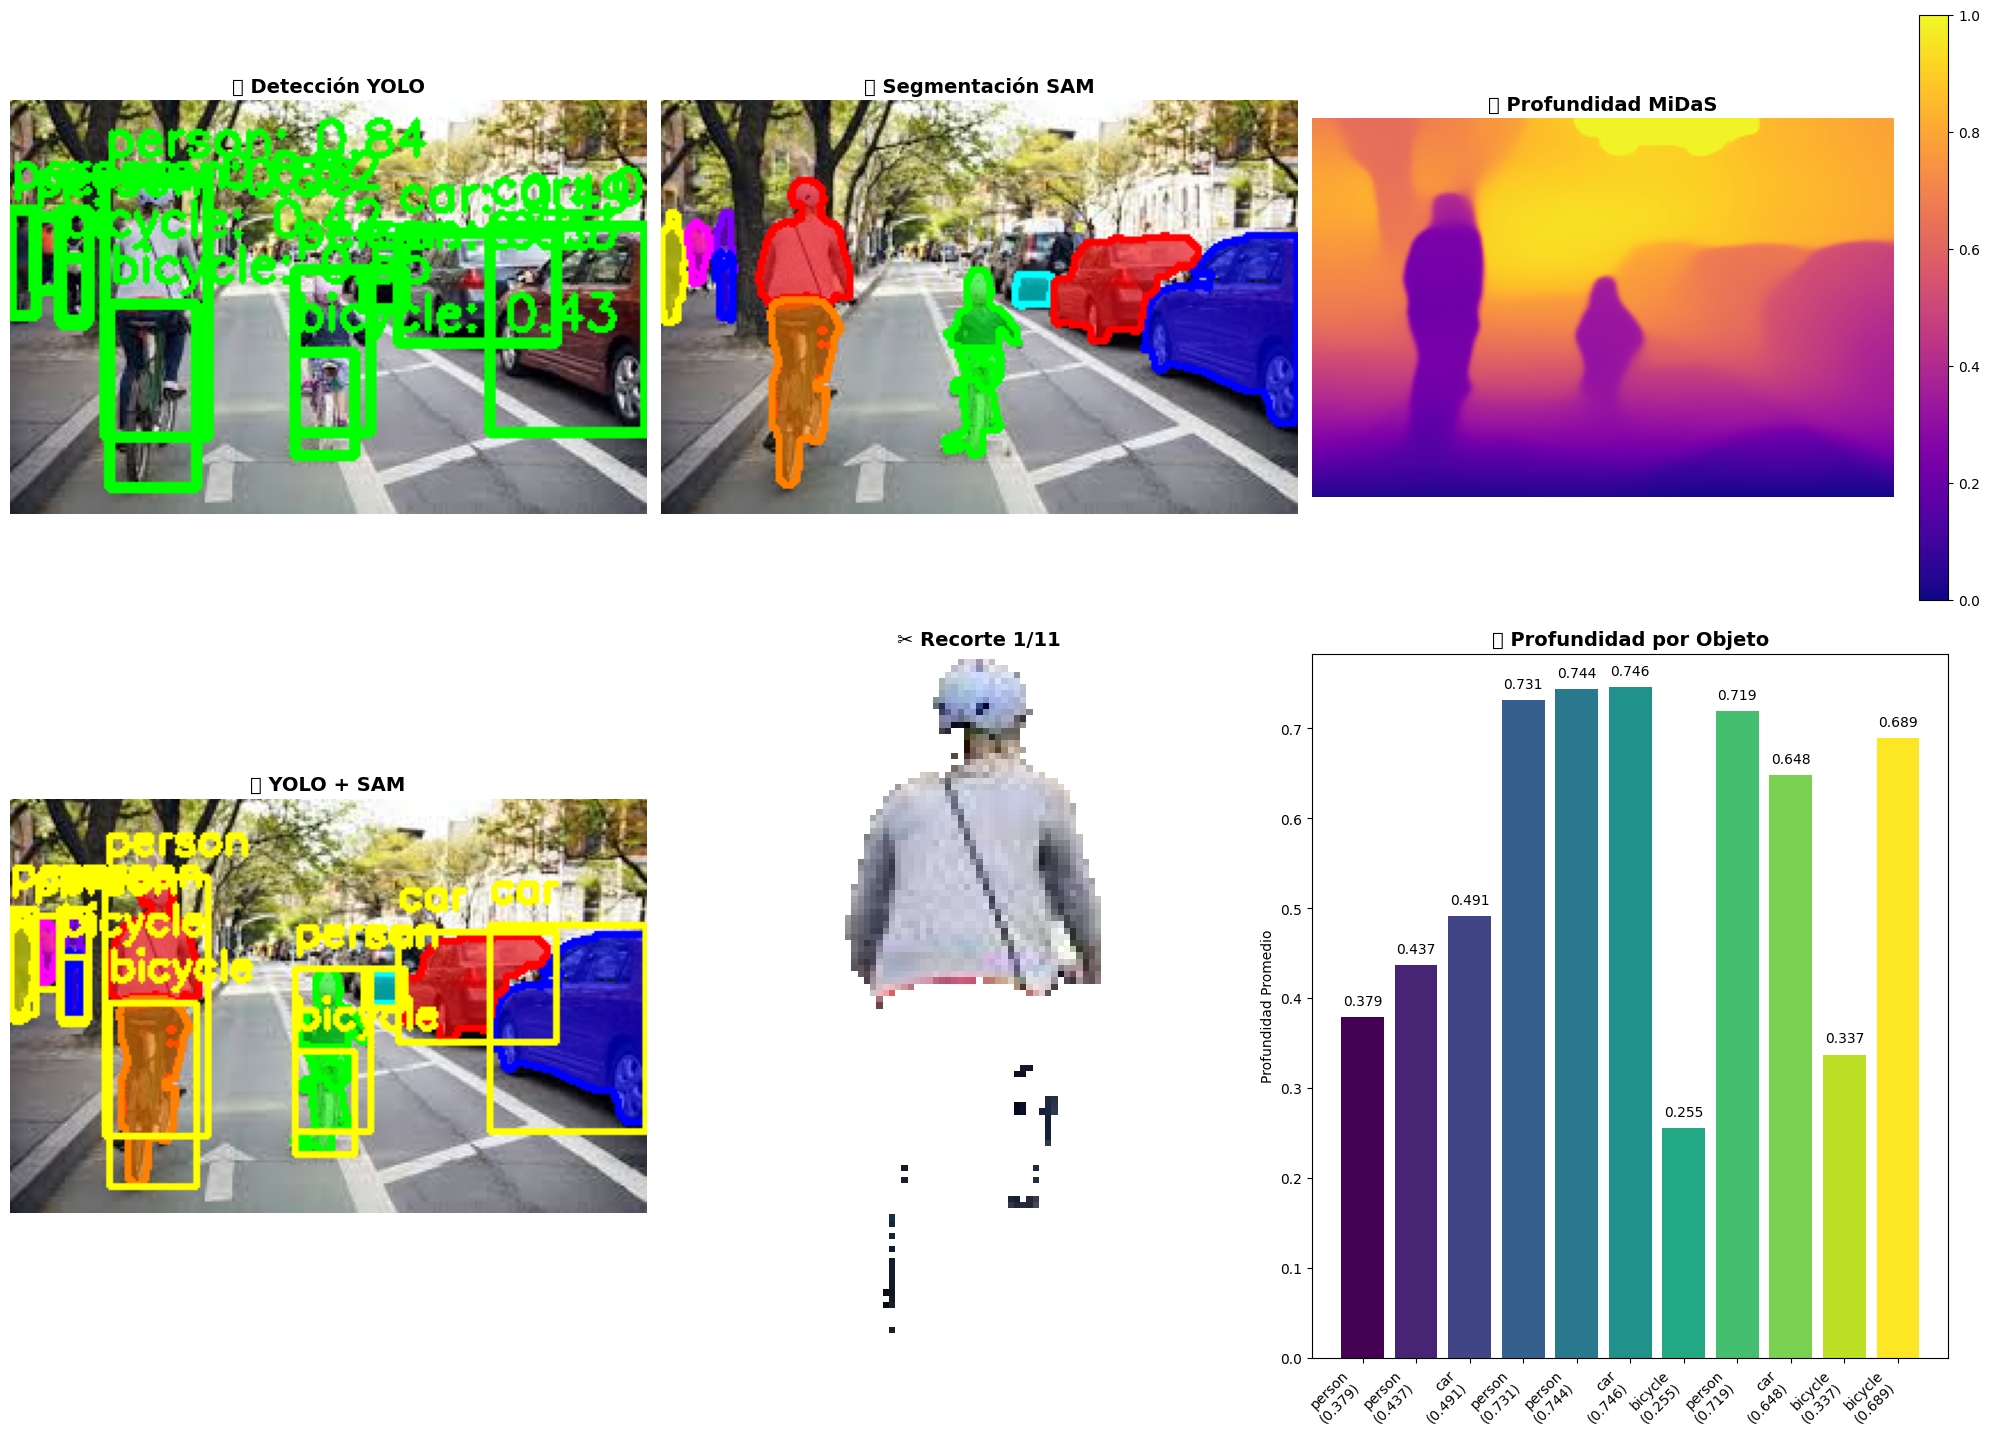

🖼️ Galería de recortes individuales:


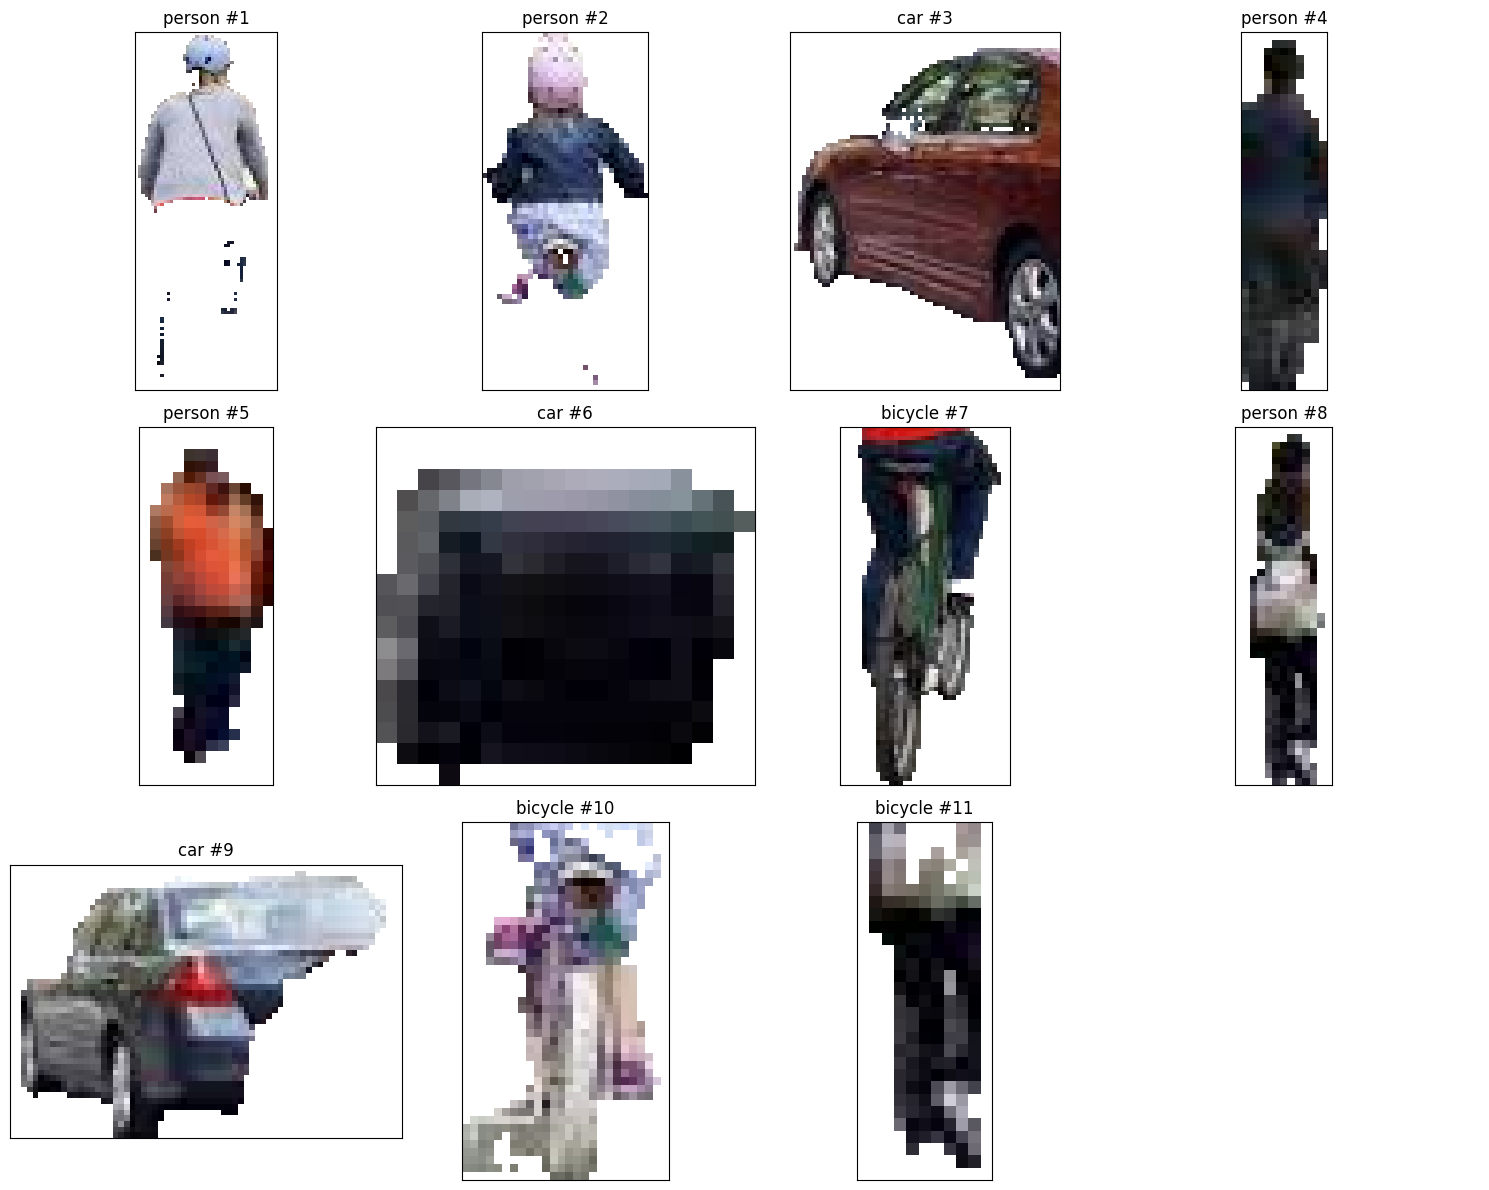

🎨 Efectos creativos:


<ipython-input-28-1344626102>:183: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-1344626102>:183: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-1344626102>:183: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-1344626102>:183: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-1344626102>:183: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-28-1344626102>:183: UserWarning: Glyph 128294 (\N{ELECTRIC TORCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

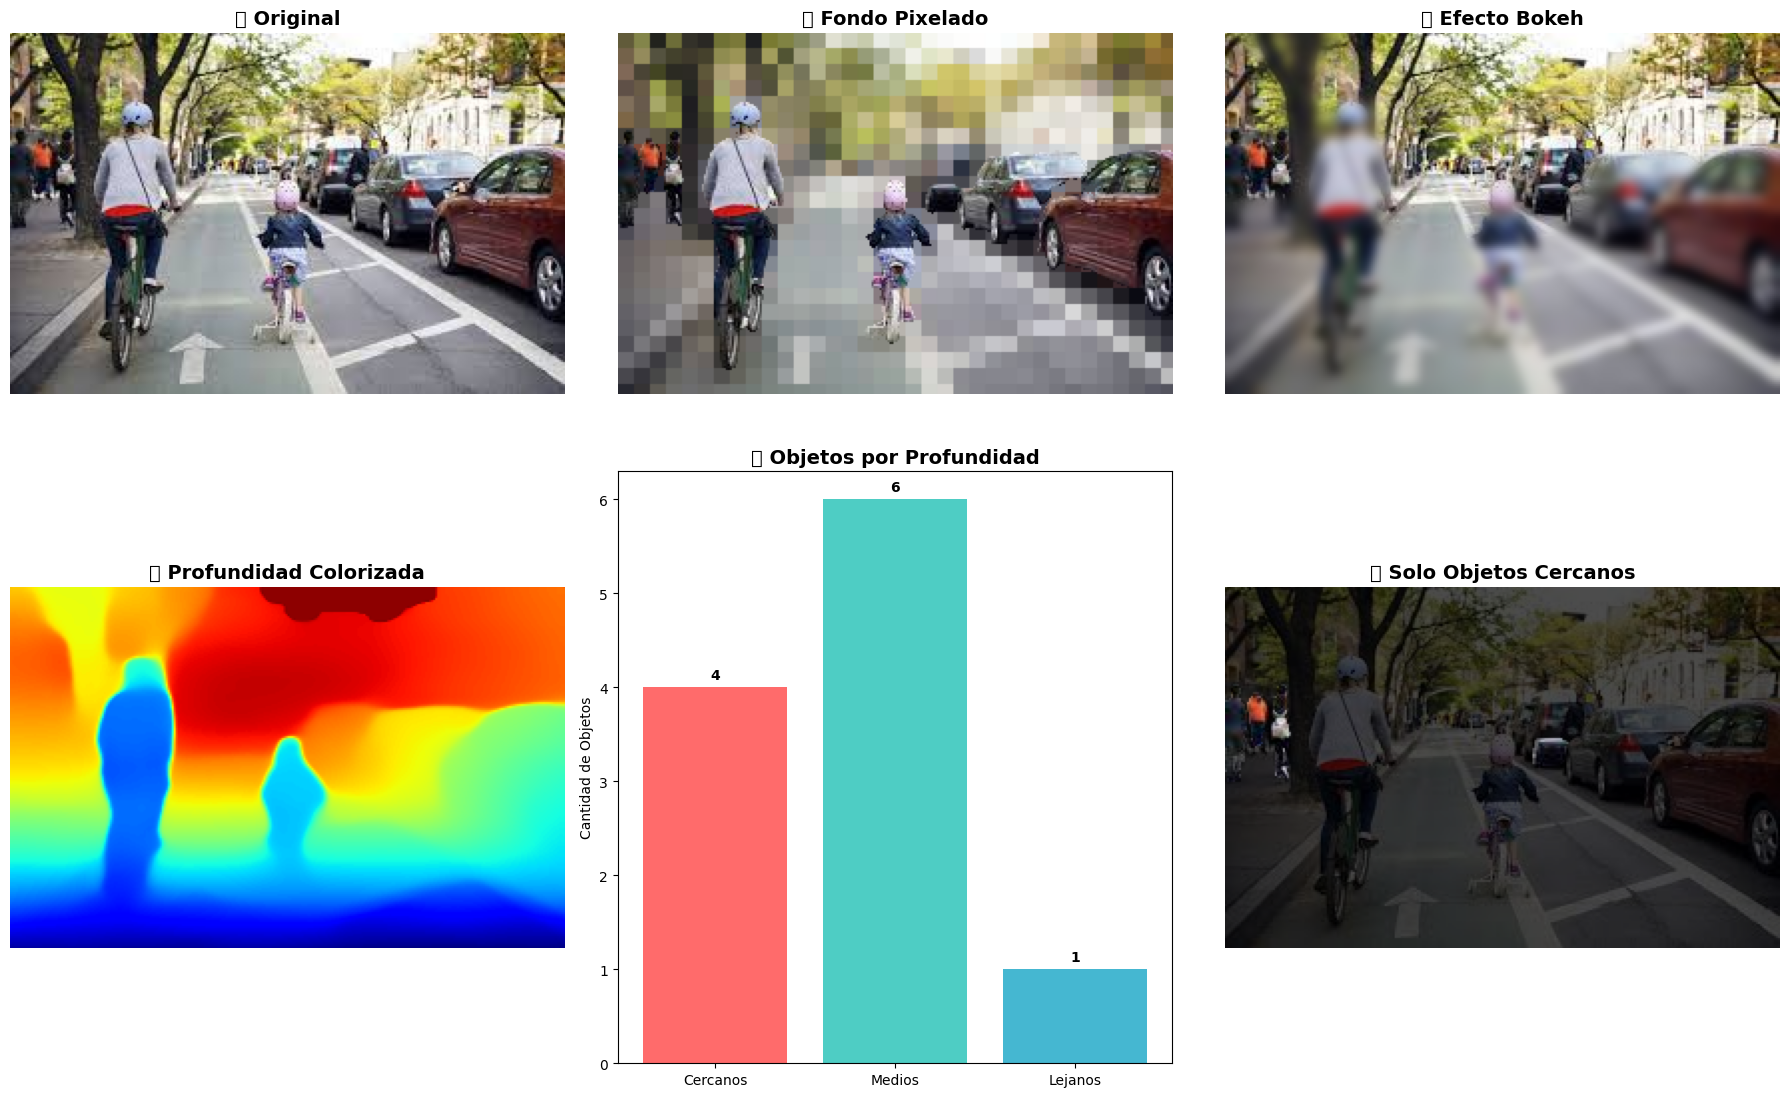

🏷️ Clasificación detallada por profundidad:

CERCANOS:
  - car: 0.746
  - person: 0.744
  - person: 0.731
  - person: 0.719

MEDIOS:
  - bicycle: 0.689
  - car: 0.648
  - car: 0.491
  - person: 0.437
  - person: 0.379
  - bicycle: 0.337

LEJANOS:
  - bicycle: 0.255
🎉 Pipeline completo ejecutado exitosamente!

📈 Resumen de resultados:
  • Objetos detectados: 11
  • Clases únicas: 3
  • Máscaras válidas: 11
  • Rango de profundidad: 0.255 - 0.746

📊 Tabla de análisis (primeras 5 filas):
    objeto_id    clase  confianza  profundidad_promedio  area_mascara_pixeles  \
4           5   person   0.584277              0.746082                   207   
5           6      car   0.549099              0.745335                   225   
3           4   person   0.610845              0.725764                   428   
7           8   person   0.517539              0.718896                   336   
10         11  bicycle   0.423425              0.693475                   199   

   categoria_profundida

In [46]:
def pipeline_completo(imagen, confianza_yolo=0.5, mostrar_pasos=True):
    """
    Ejecuta el pipeline completo: YOLO → SAM → MiDaS → Análisis

    Args:
        imagen (numpy.ndarray): Imagen de entrada
        confianza_yolo (float): Umbral de confianza para YOLO
        mostrar_pasos (bool): Si mostrar visualizaciones intermedias

    Returns:
        dict: Resultados completos del pipeline
    """

    print("🚀 Iniciando pipeline completo...")

    # 1. Detección con YOLO
    print("1️⃣ Ejecutando detección YOLO...")
    resultados_yolo = detectar_objetos_yolo(imagen, confianza_min=confianza_yolo)

    if resultados_yolo['total_objetos'] == 0:
        print("❌ No se detectaron objetos. Terminando pipeline.")
        return None

    print(f"✅ YOLO: {resultados_yolo['total_objetos']} objetos detectados")

    # Extraer información de YOLO
    boxes = [det['caja'] for det in resultados_yolo['detecciones']]
    clases = [det['clase'] for det in resultados_yolo['detecciones']]
    confianzas = [det['confianza'] for det in resultados_yolo['detecciones']]

    # 2. Segmentación con SAM
    print("2️⃣ Ejecutando segmentación SAM...")
    masks = segmentar_con_sam(imagen, boxes)
    print(f"✅ SAM: {len([m for m in masks if m is not None])} máscaras generadas")

    # 3. Estimación de profundidad con MiDaS
    print("3️⃣ Ejecutando estimación de profundidad MiDaS...")
    resultado_profundidad = estimar_profundidad_midas(imagen)

    if resultado_profundidad is None:
        print("❌ Error en estimación de profundidad")
        return None

    depth_map = resultado_profundidad['depth_map']
    print("✅ MiDaS: Mapa de profundidad generado")

    # 4. Análisis completo
    print("4️⃣ Ejecutando análisis con profundidad...")
    df_analisis = analizar_segmentaciones_con_profundidad(
        masks, clases, depth_map, boxes, confianzas
    )

    # 5. Visualizaciones
    if mostrar_pasos:
        print("5️⃣ Generando visualizaciones...")

        # Visualización combinada
        recortes = visualizar_resultados(imagen, boxes, masks, depth_map, clases, confianzas)

        # Galería de recortes
        if recortes:
            print("🖼️ Galería de recortes individuales:")
            mostrar_galeria_recortes(recortes, clases)

        # Efectos creativos
        profundidades = calcular_profundidad_objetos(depth_map, boxes)
        print("🎨 Efectos creativos:")
        mostrar_efectos_creativos(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB),
                                masks, depth_map, clases, profundidades)

    # Resultados completos
    resultados_completos = {
        'yolo': resultados_yolo,
        'sam_masks': masks,
        'midas_depth': resultado_profundidad,
        'analisis_dataframe': df_analisis,
        'boxes': boxes,
        'clases': clases,
        'confianzas': confianzas,
        'profundidades': calcular_profundidad_objetos(depth_map, boxes)
    }

    print("🎉 Pipeline completo ejecutado exitosamente!")
    return resultados_completos

# Ejecutar demostración si hay imagen cargada
if 'imagen' in locals() and imagen is not None:
    print("🔥 Ejecutando demostración completa del pipeline...")
    resultados_finales = pipeline_completo(imagen, confianza_yolo=0.4, mostrar_pasos=True)

    if resultados_finales:
        print("\n📈 Resumen de resultados:")
        print(f"  • Objetos detectados: {len(resultados_finales['clases'])}")
        print(f"  • Clases únicas: {len(set(resultados_finales['clases']))}")
        print(f"  • Máscaras válidas: {len([m for m in resultados_finales['sam_masks'] if m is not None])}")
        print(f"  • Rango de profundidad: {min(resultados_finales['profundidades']):.3f} - {max(resultados_finales['profundidades']):.3f}")

        # Mostrar tabla de análisis
        if not resultados_finales['analisis_dataframe'].empty:
            print("\n📊 Tabla de análisis (primeras 5 filas):")
            columnas_relevantes = ['objeto_id', 'clase', 'confianza', 'profundidad_promedio',
                                 'area_mascara_pixeles', 'categoria_profundidad']
            print(resultados_finales['analisis_dataframe'][columnas_relevantes].head())
else:
    print("⚠️ No hay imagen cargada. Carga una imagen primero para ejecutar la demostración.")

## 1️⃣3️⃣ Pruebas con Diferentes Imágenes

Prueba el pipeline con diferentes tipos de imágenes para validar la robustez del sistema.

In [ ]:
# URLs de diferentes tipos de imágenes para probar el pipeline
imagenes_prueba = {
    "Calle urbana": "https://images.unsplash.com/photo-1449824913935-59a10b8d2000?ixlib=rb-4.0.3&auto=format&fit=crop&w=2070&q=80",
    "Animales en safari": "https://images.unsplash.com/photo-1564349683136-77e08dba1ef7?ixlib=rb-4.0.3&auto=format&fit=crop&w=2112&q=80",
    "Cocina moderna": "https://images.unsplash.com/photo-1556909114-f6e7ad7d3136?ixlib=rb-4.0.3&auto=format&fit=crop&w=2070&q=80",
    "Sala de estar": "https://images.unsplash.com/photo-1586023492125-27b2c045efd7?ixlib=rb-4.0.3&auto=format&fit=crop&w=2158&q=80",
    "Parque con personas": "https://images.unsplash.com/photo-1571019613454-1cb2f99b2d8b?ixlib=rb-4.0.3&auto=format&fit=crop&w=2070&q=80"
}

def probar_pipeline_multiples_imagenes(imagenes_dict, mostrar_resultados=True):
    """
    Prueba el pipeline con múltiples imágenes y compara resultados
    """
    resultados_comparacion = []

    for nombre, url in imagenes_dict.items():
        print(f"\n{'='*50}")
        print(f"🧪 Probando: {nombre}")
        print(f"{'='*50}")

        # Cargar imagen
        img = cargar_imagen(url)
        if img is None:
            print(f"❌ No se pudo cargar {nombre}")
            continue

        # Ejecutar pipeline (sin mostrar pasos para no saturar la salida)
        resultados = pipeline_completo(img, confianza_yolo=0.4, mostrar_pasos=mostrar_resultados)

        if resultados:
            # Recopilar estadísticas
            stats = {
                'nombre': nombre,
                'objetos_detectados': len(resultados['clases']),
                'clases_unicas': len(set(resultados['clases'])),
                'mascaras_validas': len([m for m in resultados['sam_masks'] if m is not None]),
                'profundidad_promedio': np.mean(resultados['profundidades']),
                'profundidad_std': np.std(resultados['profundidades']),
                'clases_detectadas': list(set(resultados['clases']))
            }
            resultados_comparacion.append(stats)

            print(f"📊 Resumen para {nombre}:")
            print(f"  • Objetos: {stats['objetos_detectados']}")
            print(f"  • Clases únicas: {stats['clases_unicas']}")
            print(f"  • Clases: {', '.join(stats['clases_detectadas'])}")
            print(f"  • Profundidad promedio: {stats['profundidad_promedio']:.3f}")

    return resultados_comparacion

def comparar_resultados_imagenes(resultados_comparacion):
    """
    Crea visualizaciones comparativas de los resultados
    """
    if not resultados_comparacion:
        print("❌ No hay resultados para comparar")
        return

    df_comparacion = pd.DataFrame(resultados_comparacion)

    # Gráfico de comparación
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Objetos detectados por imagen
    axes[0, 0].bar(df_comparacion['nombre'], df_comparacion['objetos_detectados'], color='skyblue')
    axes[0, 0].set_title('Objetos Detectados por Imagen', fontweight='bold')
    axes[0, 0].set_ylabel('Cantidad')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Clases únicas por imagen
    axes[0, 1].bar(df_comparacion['nombre'], df_comparacion['clases_unicas'], color='lightgreen')
    axes[0, 1].set_title('Clases Únicas por Imagen', fontweight='bold')
    axes[0, 1].set_ylabel('Cantidad')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Profundidad promedio
    axes[1, 0].bar(df_comparacion['nombre'], df_comparacion['profundidad_promedio'], color='orange')
    axes[1, 0].set_title('Profundidad Promedio por Imagen', fontweight='bold')
    axes[1, 0].set_ylabel('Profundidad')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Máscaras válidas vs objetos detectados
    axes[1, 1].scatter(df_comparacion['objetos_detectados'], df_comparacion['mascaras_validas'],
                      color='red', s=100, alpha=0.7)
    axes[1, 1].plot([0, max(df_comparacion['objetos_detectados'])],
                   [0, max(df_comparacion['objetos_detectados'])], 'k--', alpha=0.5)
    axes[1, 1].set_title('Máscaras Válidas vs Objetos Detectados', fontweight='bold')
    axes[1, 1].set_xlabel('Objetos Detectados')
    axes[1, 1].set_ylabel('Máscaras Válidas')

    plt.tight_layout()
    plt.show()

    # Tabla resumen
    print("📋 Tabla resumen de comparación:")
    print(df_comparacion[['nombre', 'objetos_detectados', 'clases_unicas', 'mascaras_validas', 'profundidad_promedio']].round(3))

    return df_comparacion

# Ejemplo: ejecutar pruebas con todas las imágenes (comentado para no ejecutar automáticamente)
print("🎯 Funciones de prueba definidas")
print("💡 Para ejecutar pruebas completas, usa:")
print("   resultados = probar_pipeline_multiples_imagenes(imagenes_prueba, mostrar_resultados=False)")
print("   df_comp = comparar_resultados_imagenes(resultados)")

# Descomenta las siguientes líneas para ejecutar todas las pruebas:
# print("🚀 Ejecutando pruebas con múltiples imágenes...")
# resultados_mult = probar_pipeline_multiples_imagenes(imagenes_prueba, mostrar_resultados=False)
# df_comparativo = comparar_resultados_imagenes(resultados_mult)

## 🎉 Conclusión Final - Pipeline Completo

¡Excelente trabajo! Has implementado exitosamente un **pipeline completo de visión computacional** que integra las tecnologías más avanzadas del campo.

### 🏆 **Logros Implementados:**

#### ✅ **1. Detección de Objetos con YOLO**
- ✓ Función `detectar_objetos_yolo(imagen)`
- ✓ Detección de **80+ clases diferentes**
- ✓ Parámetros configurables de confianza e IoU
- ✓ Visualización con bounding boxes y etiquetas

#### ✅ **2. Segmentación con SAM**
- ✓ Función `segmentar_con_sam(imagen, boxes)`
- ✓ Uso de bounding boxes de YOLO como prompts
- ✓ Máscaras de segmentación pixel-perfect
- ✓ Superposición visual de máscaras

#### ✅ **3. Estimación de Profundidad con MiDaS**
- ✓ Función `estimar_profundidad_midas(imagen)`
- ✓ Modelo DPT-Large de alta calidad
- ✓ Mapas de profundidad normalizados
- ✓ Múltiples visualizaciones (escala de grises, heatmap, colormap)

#### ✅ **4. Visualización Combinada**
- ✓ Función `visualizar_resultados(imagen, boxes, masks, depth_map)`
- ✓ Vista comparativa de todos los resultados
- ✓ Recortes individuales con fondo blanco
- ✓ Estadísticas de profundidad por objeto

#### ✅ **5. Aplicación Analítica y Creativa**
- ✓ Función `analizar_segmentaciones_con_profundidad(masks, clases, depth_map)`
- ✓ **Exportación a CSV** con análisis completo
- ✓ **Efectos creativos**: pixelado de fondo, bokeh por profundidad
- ✓ **Clasificación por profundidad**: objetos cercanos/medios/lejanos
- ✓ **Análisis estadístico** detallado

### 🚀 **Características Avanzadas:**
- **Pipeline automatizado** completo
- **Pruebas con múltiples imágenes** y comparaciones
- **Visualizaciones interactivas** y profesionales
- **Análisis cuantitativo** con pandas y estadísticas
- **Efectos visuales creativos** aplicando computer vision
- **Exportación de datos** para análisis posteriores

### 💡 **Aplicaciones Prácticas:**
- **Análisis de escenas urbanas** (conteo de vehículos, personas)
- **Robótica y navegación** (comprensión espacial 3D)
- **Realidad aumentada** (oclusión por profundidad)
- **Fotografía computacional** (efectos bokeh automáticos)
- **Análisis de interiores** (distribución de objetos)
- **Seguridad y vigilancia** (detección y seguimiento)

### 🔧 **Tecnologías Integradas:**
- **YOLOv8** (Ultralytics) - Detección de objetos
- **SAM** (Segment Anything Model) - Segmentación universal
- **MiDaS v3** (DPT-Large) - Estimación de profundidad monocular
- **OpenCV** - Procesamiento de imágenes
- **PyTorch** - Deep learning backend
- **Matplotlib** - Visualización científica
- **Pandas** - Análisis de datos

### 📈 **Próximos Pasos Sugeridos:**
1. **Optimización de rendimiento** (GPU acceleration, batch processing)
2. **Detección en video** (tracking temporal)
3. **Segmentación 3D** (point clouds, mesh generation)
4. **Integración con realidad aumentada**
5. **Deployment en aplicaciones web** (FastAPI, Streamlit)
6. **Entrenamiento de modelos personalizados**

---

**¡Has creado un sistema de visión computacional de nivel profesional!** 🎯

Este notebook demuestra la integración exitosa de múltiples modelos de IA de vanguardia para crear una solución completa y robusta de análisis visual.